In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Load the data
data = pd.read_parquet('train-00000-of-00001-b21313e511aa601a.parquet')

# Display the first 5 rows of the data
data.head()

,bibcode,title,abstract,verified_uat_ids,verified_uat_labels
0,2020ApJ...891..100S,Dynamic Potential Sputtering of Lunar Analog M...,"Pyroxenes ((Ca, Mg, Fe, Mn)<SUB>2</SUB>Si<SUB>...","[1534, 499, 1692, 948, 1024, 2004]","[solar wind, exosphere, the moon, lunar compos..."
1,2024ApJ...966L...8B,"Generation of Low-inclination, Neptune-crossin...",The solar system's distant reaches exhibit a w...,"[1705, 1184, 2293]","[trans-neptunian objects, orbits, solar system..."
2,2024PSJ.....5...45C,Leveraging the Gravity Field Spectrum for Icy ...,Understanding the interior structures of icy m...,"[2189, 1248, 770, 1889, 627, 1255]","[europa, planetary interior, hydrosphere, mark..."
3,2022ApJ...932...52H,Inverse Multiview. I. Multicalibrator Inverse ...,Very Long Baseline Interferometry (VLBI) astro...,"[1769, 1337, 1713, 1295]","[very long baseline interferometry, radio astr..."
4,2024ApJS..271...25C,The First LHAASO Catalog of Gamma-Ray Sources,We present the first catalog of very-high-ener...,"[628, 632, 205]","[gamma-ray astronomy, gamma-ray observatories,..."


After Loading the data, we're going to train our model

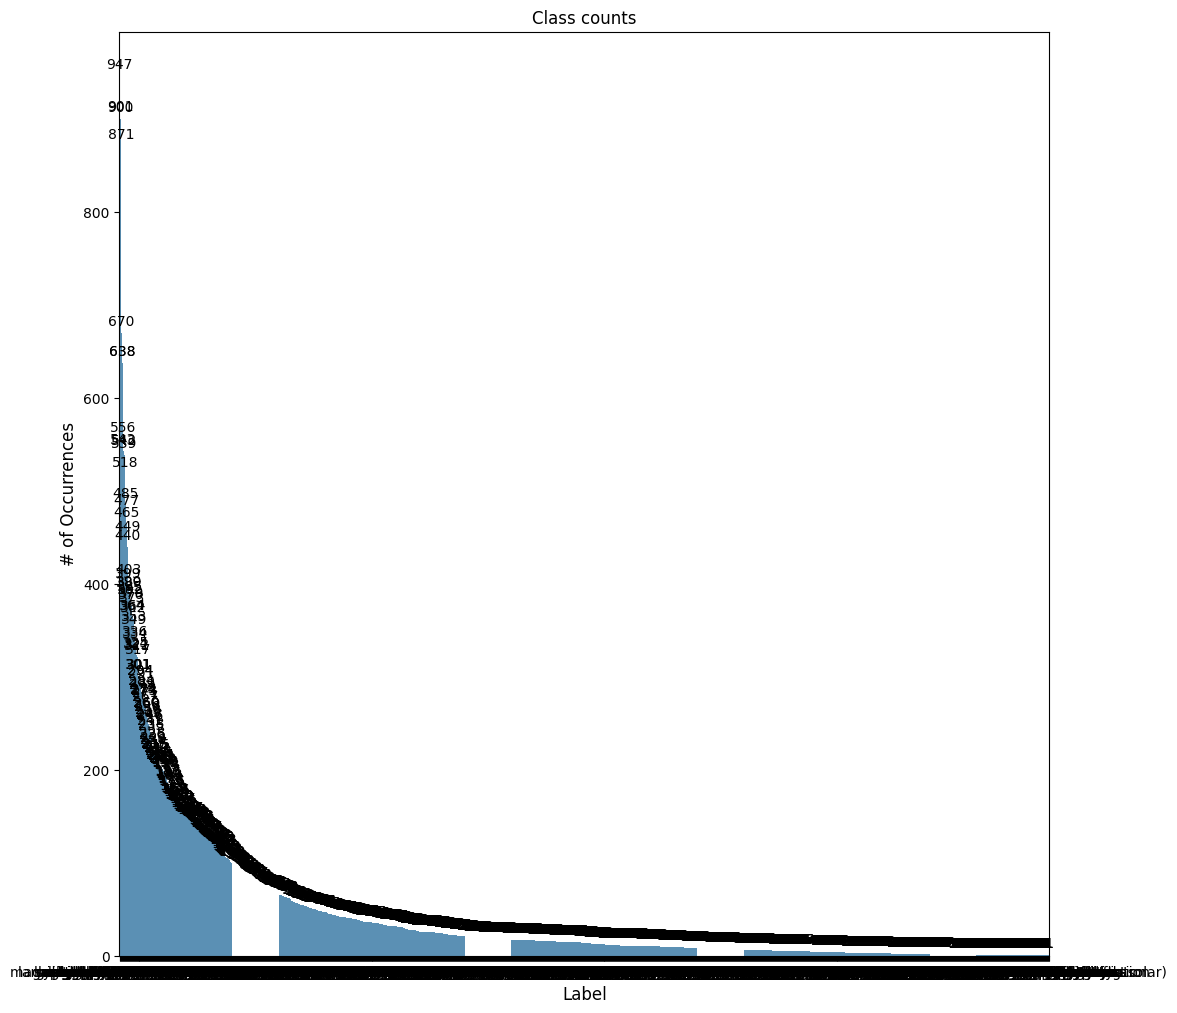

In [ ]:
X = data.drop(columns=['verified_uat_labels']).drop(columns=['verified_uat_ids'])
Y = data[data.columns[-2:]]

Y
